# Binnagio del serpentino

This tutorial aims at demonstrating use cases and for improving Hi-C contact maps with distribution-aware binning, helping readers reproduce the steps in Scolari et al., 2018 and documenting readers with the implementation.

## Loading the library

You can directly use the library's functions, if you are already manipulating numpy contact maps in your analysis. First, you need to import the library with the following:

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import serpentine as sp

After, you need to load your datasets with numpy, we provide a couple of demo datasets in the form of tables, corresponding to Yeast chromosome 7 in two different mutants, in the repository:

In [4]:
# Load Yeast data
A = np.loadtxt('demo/A.csv')
B = np.loadtxt('demo/B.csv')

At this point you are working with raw Hi-C data, serpentine provides convenient function to visualize your material:

### The first dataset:

<IPython.core.display.Javascript object>


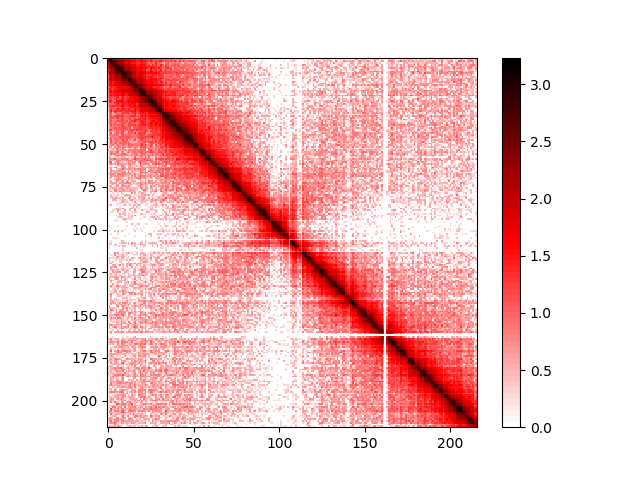

In [5]:
fig = plt.figure()
sp.mshow(A);

### The second dataset:

<IPython.core.display.Javascript object>


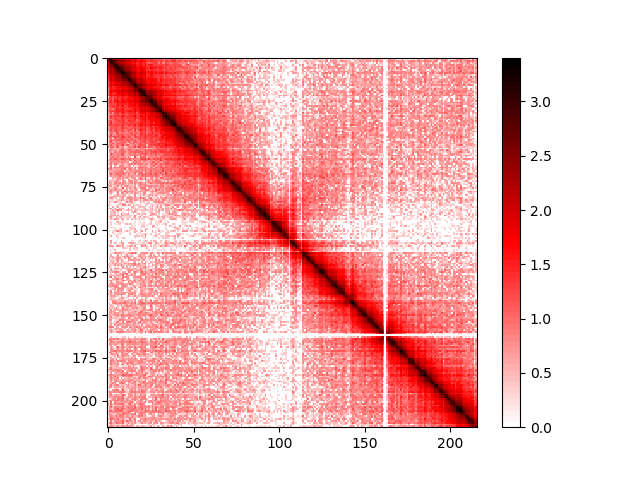

In [6]:
fig = plt.figure()
sp.mshow(B)

## Filtering of the data

The raw data needs to be filtered in order to clean the unmappable rows and columns, this kind of artefact show up in the distribution of reads per bin as outliers:

<IPython.core.display.Javascript object>


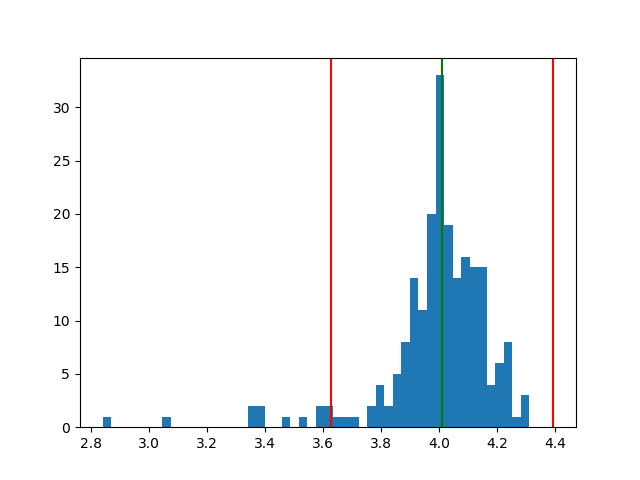

In [8]:
plt.figure()
norm = np.log10(np.sum(A + B, axis=0)[np.sum(A + B, axis=0) > 0])
norm = norm[np.isnan(norm) == False]
norm = norm[np.isinf(np.abs(norm)) == False]
plt.hist(norm, bins=50)
plt.axvline(x=np.median(norm), color='g')
plt.axvline(x=np.median(norm) - 3 * 1.4826 * sp.mad(norm), color='r')
plt.axvline(x=np.median(norm) + 3 * 1.4826 * sp.mad(norm), color='r')

with serpentine this is easily achievable using the two included functions

In [9]:
flt = sp.filter(A) + sp.filter(B)
flt = flt == False
A = sp.fltmatr(A, flt)
B = sp.fltmatr(B, flt)

resulting in:

<IPython.core.display.Javascript object>


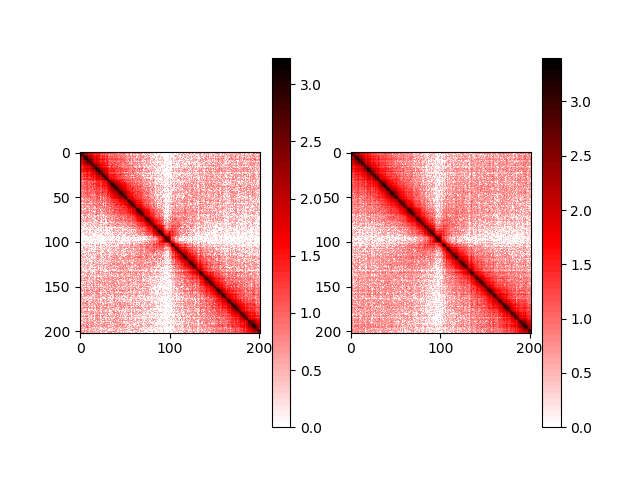

In [10]:
fig = plt.figure();
ax1 = fig.add_subplot(1, 2, 1); sp.mshow(A, subplot=ax1);
ax2 = fig.add_subplot(1, 2, 2); sp.mshow(B, subplot=ax2);

at this point, other manipulation can be done before proceeding, such as iterative normalizations, despekling or other treatments.

## Finding the binning threshold and the detrending constant

The coverage of the data will impact the amount of rebinning the algorithm needs to perform well. On top of that, comparing matrixes at different general coverage imply finding the trending constant that need to be subtracted to the result. In order to do this, our library provides a tool in the form of an mean-difference (MD) plot. The plot shows the log-ratio in function of the intensity of the signal. This graph suggests that the data have a characteristic noise-to-signal ratio at large coverages that becomes much larger at lower coverages due to sampling noise.

The function MDbefore permits to find the optimal trending and threshold values, the graphs higlight the median and the median absolute deviation as red and green lines as a function of the mean contact number:

<IPython.core.display.Javascript object>


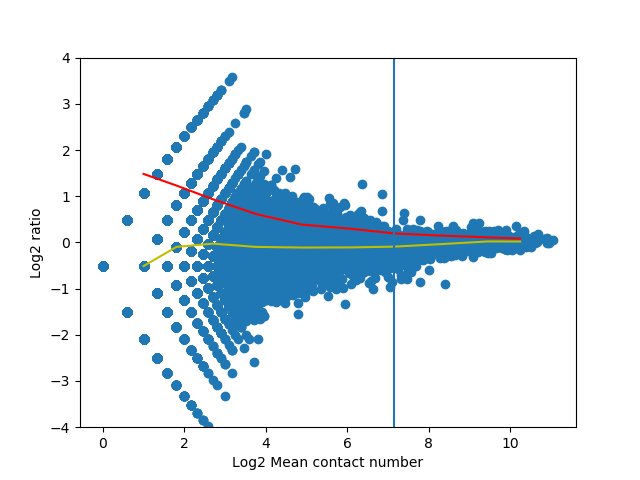

0.51213841405 142.249780316


In [11]:
# Find the detrending and threshold
plt.figure();
trend, threshold = sp.MDbefore(A, B, ylim=[-4, 4]);
print(trend,threshold)

## Serpenting binning the data

Finally you can use the function to bin the data. The function takes two parameters: a threshold that constrains the coverage of the bin in at least one matrix, and the minthreshold that constrain it in both. The function uses multiple processors and can be configured by the optional parameters:

In [12]:
sA, sB, sK = sp.serpentin_binning(A, B, threshold, threshold / 5)

Starting 10 binning processes in batches of 16...
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
1	 Total serpentines: 13922 (67.90225820611617 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
0	 Total serpentines: 20503 (100.0 %)
1	 Total serpentines: 13923 (67.90713554114032 %)
2	 Total serpentines: 5408 (26.376627810564308 %)
1	 Total serpentines: 13840 (67.50231673413647 %)
1	 Total serpentines: 13928 (67.93152221626103 %)
1	 Total serpentines: 13925 (67.9168902111886 %)
1	 Total serpentines: 13916 (67.87299419597132 %)
1	 Total serpentines: 13940 (67.99005023655074 %)
1	 Total serpentines: 13864 (67.6193727747159 %)
3	 Total serpentines: 2662 (12.983465834268156 %)
2	 Total serpentines: 5395 (26.31322245525045 %)
1	 Total serpentines: 1

## Checking the results

The quality of the binning can be checked by an MD plot. This time, use the MDafter function, if the process was successful you would expect the effect of sampling to be reduced by binning, and an almost constant signal-to-noise value at all values of contact numbers similar to the one at large contact numbers:

<IPython.core.display.Javascript object>


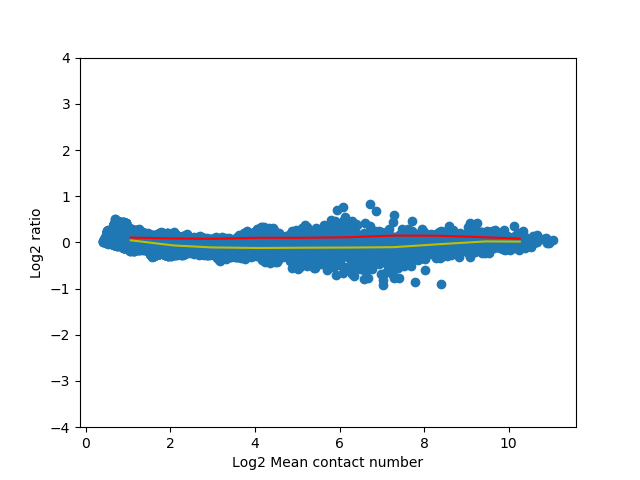

0.51443105936050415

In [13]:
plt.figure()
sp.MDafter(sA, sB, sK, ylim=[-4, 4])

Matrices have been rebinned, and the characteristic sampling noise present at small coverages is now been smoothed, while the crisp signal at large coverages, conveying the precious biological variations is preserved:

<IPython.core.display.Javascript object>


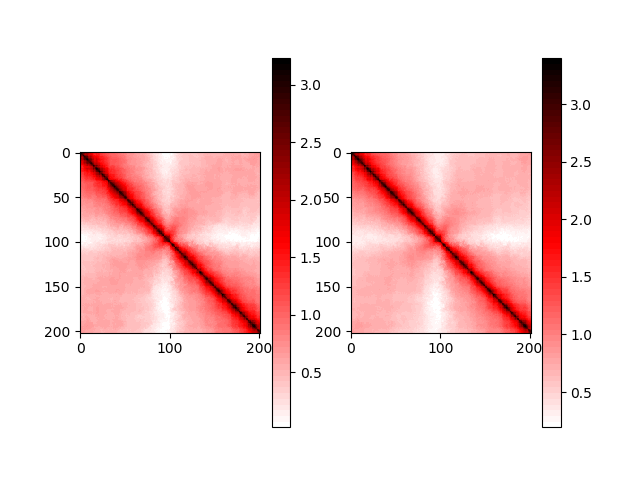

In [14]:
fig = plt.figure();
ax1 = fig.add_subplot(1, 2, 1); sp.mshow(sA, subplot=ax1);
ax2 = fig.add_subplot(1, 2, 2); sp.mshow(sB, subplot=ax2);

## Checking the differential analysis

Similarly, we improved the differential analysis, before the binning, we could have obtained this kind of results:

### Before binning:

<IPython.core.display.Javascript object>


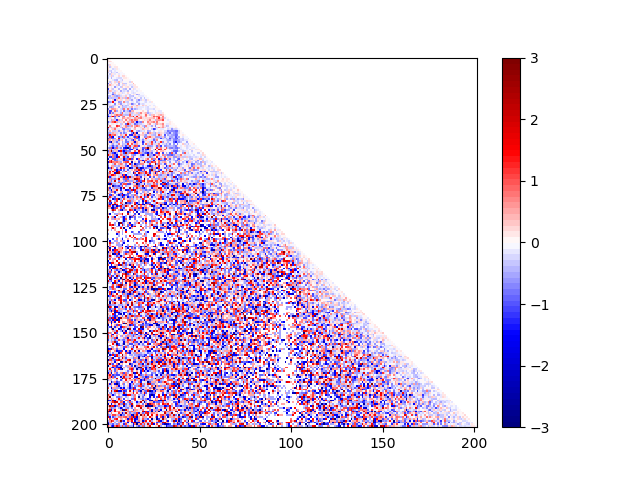

In [15]:
plt.figure()
np.warnings.filterwarnings('ignore');
D = np.log2(B/A)
sp.dshow(D, trend)

Now,

### After binning:

<IPython.core.display.Javascript object>


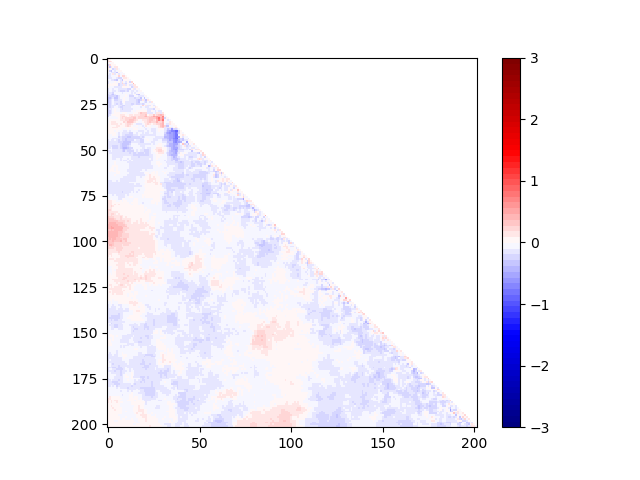

In [16]:
plt.figure()
sp.dshow(sK, trend)